# Introduction to Coba
Coba was built to study the performance of contextual bandit learners. To perform an experiment in coba we need two things:
1. **Simulations**: Unique environments containing interactions and rewards for Learner evaluation.
2. **Learners**: Implementations of contextual bandit algorithms capable of learning in an online setting.

Simulations represent unique environments that we want our contextual bandit learners to perform within while learners are the actual contextual bandit algorithms that we'd like to evaluate. Coba provides a number of learners and simulations out of the box which we will use in below. Once you get a feel for the basics here next steps will be to implement your own simulations and learners.

## Your First Coba Experiment
### Selecting Simulations
Every experiment in Coba begins by selecting which simulations to use to evaluating learners. 

We're going to start with a really simple simulation, **ValidationSimulation**, which was designed to validate that learners are working as expected.

In [1]:
from coba.simulations import ValidationSimulation

### Selecting Learners
Next an experiment needs some learners to evaluate. Coba comes with a number of existing learners. We're going to pick three:
1. **RandomLearner**: This learner randomly selects actions. It is useful as a comparison to make sure learners are actually "learning".
2. **EpsilonBanditLearner**: This learner follows an epsilon greedy policy when selecting actions and ignores context features.
3. **VowpalLearner**: This learner is a wrapper around the Vowpal Wabbit ML package that implements several contextual bandit algorithms.

In [2]:
from coba.learners import RandomLearner, EpsilonBanditLearner, VowpalLearner

### Running the Experiment
Now that we've selected our simulation and learners we are ready to run our experiment. Experiments in Coba are orchestrated by the Benchmark class. This class takes care of all the hard work of actually evaluating our learners against our simulations. Creating and running our first experiment looks like this:

2021-08-16 14:57:42 Processing chunk...
2021-08-16 14:57:42   * Creating source 0 from Validation... (0.0 seconds) (completed)
2021-08-16 14:57:42   * Creating simulation 0 from source 0... (0.0 seconds) (completed)
2021-08-16 14:57:42   * Calculating Simulation 0 statistics... (0.02 seconds) (completed)
2021-08-16 14:57:42   * Evaluating learner 0 on Simulation 0... (0.01 seconds) (completed)
2021-08-16 14:57:42   * Evaluating learner 1 on Simulation 0... (0.02 seconds) (completed)
2021-08-16 14:57:43   * Evaluating learner 2 on Simulation 0... (0.19 seconds) (completed)


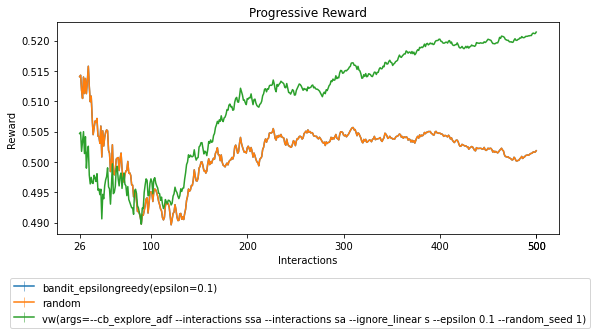

In [1]:
from coba.simulations import ValidationSimulation
from coba.learners    import RandomLearner, EpsilonBanditLearner, VowpalLearner
from coba.benchmarks  import Benchmark

simulations = [ ValidationSimulation() ]
learners    = [ RandomLearner(), EpsilonBanditLearner(0.1), VowpalLearner() ]

Benchmark(simulations).evaluate(learners).plot_learners()

And just like that we've run our first experiment in Coba. 

Taking a quick moment to explain the plot, the X-axis indicates how many times our learners have interacted with the simulation while the Y-axis indicates the average reward received since the beginning of the Benchmark. The legend below the plot shows each learner and their hyperparameters. 

Of course, running a single experiment often leads to more questions. Where is the **RandomLearner** in the plot? In this case it is immediately beneath **EpsilonBanditLearner**. There are a few reasons for why this happened so let's see if we can't figure this out by running a second experiment.

## Your Second Coba Experiment
As we mentioned above bandit learners don't consider context or action features when choosing actions. For our second experiment then we're going to modify the **ValidationSimulation** to see what parameters are causing this strange behavior. Look at the **ValidationExperiment** in this new code and notice the new parameter `action_features=False`.

2021-08-16 14:57:47 Processing chunk...
2021-08-16 14:57:47   * Creating source 0 from Validation... (0.0 seconds) (completed)
2021-08-16 14:57:47   * Creating simulation 0 from source 0... (0.0 seconds) (completed)
2021-08-16 14:57:47   * Calculating Simulation 0 statistics... (0.02 seconds) (completed)
2021-08-16 14:57:47   * Evaluating learner 0 on Simulation 0... (0.02 seconds) (completed)
2021-08-16 14:57:47   * Evaluating learner 1 on Simulation 0... (0.03 seconds) (completed)
2021-08-16 14:57:47   * Evaluating learner 2 on Simulation 0... (0.14 seconds) (completed)


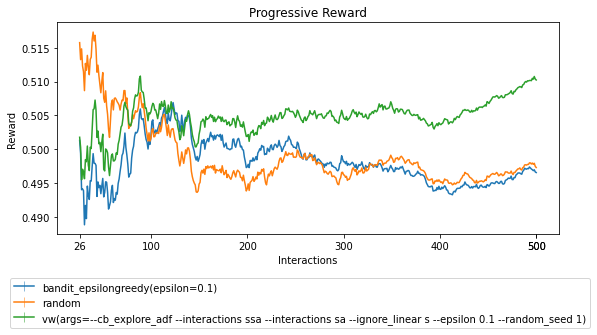

In [2]:
from coba.simulations import ValidationSimulation
from coba.learners    import RandomLearner, EpsilonBanditLearner, VowpalLearner
from coba.benchmarks  import Benchmark

simulations = [ValidationSimulation(action_features=False)]
learners    = [RandomLearner(), EpsilonBanditLearner(0.1), VowpalLearner()]

Benchmark(simulations).evaluate(learners).plot_learners()

Look at that! **EpsilonBanditLearner** and **RandomLearner** are no longer identical. So what happened? 

When we set `action_features=False` this changed the **ValidationSimulation** so that its actions no longer had "features". To understand this intuitively imagine we wanted to make a contextual bandit that recommended movies. Our actions in this case would be movies and each movie may have certain features that helps us decide what to recommend like its genre or critic rating. When we set action_features=False this changed the simulation to something more like recommending a leisurely activity like reading, watching a movie or going for a walk. We are still able to distinguish the actions but the actions no longer have features like genre. Why do you think this changed the performance of **EpsilonBanditLearner**?

Ok, time for one final experiment. Let's see if we can get **EpsilonBanditLearner** performing competitively.

## One Final Experiment
For this final experiment we'll make one more change to **ValidationSimulation** along with adding a parameter to Benchmark, `shuffle=[1,2,3,4]`.

2021-08-16 14:57:51 Processing chunk...
2021-08-16 14:57:51   * Creating source 0 from Validation... (0.0 seconds) (completed)
2021-08-16 14:57:51   * Creating simulation 0 from source 0... (0.0 seconds) (completed)
2021-08-16 14:57:51   * Calculating Simulation 0 statistics... (0.02 seconds) (completed)
2021-08-16 14:57:51   * Evaluating learner 0 on Simulation 0... (0.02 seconds) (completed)
2021-08-16 14:57:51   * Evaluating learner 1 on Simulation 0... (0.03 seconds) (completed)
2021-08-16 14:57:51   * Evaluating learner 2 on Simulation 0... (0.11 seconds) (completed)
2021-08-16 14:57:51   * Creating simulation 1 from source 0... (0.0 seconds) (completed)
2021-08-16 14:57:51   * Calculating Simulation 1 statistics... (0.02 seconds) (completed)
2021-08-16 14:57:51   * Evaluating learner 0 on Simulation 1... (0.02 seconds) (completed)
2021-08-16 14:57:51   * Evaluating learner 1 on Simulation 1... (0.03 seconds) (completed)
2021-08-16 14:57:51   * Evaluating learner 2 on Simulation 1

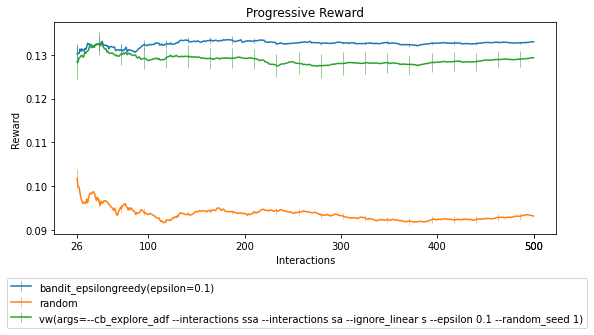

In [3]:
from coba.benchmarks import Benchmark

simulations = [ValidationSimulation(action_features=False, context_features=False)]
learners    = [RandomLearner(), EpsilonBanditLearner(0.1), VowpalLearner()]

result = Benchmark(simulations, shuffle=[1,2,3,4]).evaluate(learners)
result.plot_learners(err='se')

Wow, there was a lot more output that time. We'll come back to that in a second but first, look at that plot. Our underdog, **EpsilonBanditLearner** is finally hanging with the big boys. With context_features and action_features turned off we're now evaluating against a multi-armed bandit simulation. This is actually what bandit algorithms are designed for and sure enough we can see **EpsilonBanditLearner** performs well in this simulation. 

What are those new lines though on the plot? Those weren't there before. Those are there because we specified `shuffle`. In fact the reason there was so much more output with this experiment is also because of `shuffle`. The shuffle parameter of **Benchmark** tells the benchmark to run its simulations `n` times (where `n` is the length of the `shuffle` list) so there is `n` times more output. For each of the `n` simulation runs **Benchmark** will shuffle the order of interactions given to the learners according to the random seeds we provided (in this case 1, 2, 3, and 4). The bars drawn on the plot are the standard deviations of our learners across these shuffles. To get a sense of this visually we can create a new plot that will show the shuffles along with the average.


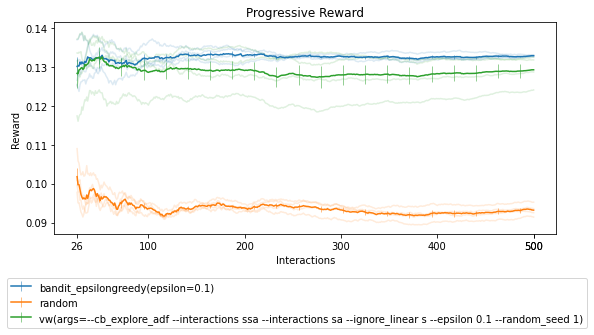

In [4]:
result.plot_learners(err='se', each=True)

This plot shows our learner's average performance (The solid blue line in the middle) superimposed on top of the learner's performance on each of our four shuffles. We can see now that performance can actually vary quite a bit depending on the order of the interactions. What about with the **VowpalWabbit** learner when it is using epsilon greedy? (Though we should keep in mind that VW is a contextual bandit learner that we've already seen is much more general learner than **EpsilonBanditLearner** so its not really a fair comparison.)

## Conclusion
We hope this brief introduction has gotten you excited about the possibilities of COBA. What would you like to do first with Coba? Do you have an algorithm that you're hoping to publish and would like to easily test against other learners? Do you have a data set that you'd like to build a simulation from to see which contextual bandit algorithm performs best on it? Or are you just trying to learn more about machine learning and are just looking for an easy way to test introductory algorithms while you learn? All the above are easy to do with Coba. 

We also welcome code contributions for new features. Feel free to reach out to mr2an@virginia.edu for ideas about features that Coba could benefit from. Coba is able to do a lot more than what we've shown here. It has its own benchmarking syntax to allow you to define benchmarks in a separate file for easy sharing. It is able to import Simulations from a number of data formats. It is able to manage resource constraints to maximize through put of long running Benchmarks. It can download remote data sets. All of this functionality has grown out of our own experimental needs and so we hope most of what 